### Import packages

In [1]:
import pyemma as py
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from scipy.stats import pearsonr

### Import distances

In [2]:
# import distances:
load_path = '../'
# WT:
which_system = '1m47_c125s'
distances_data_wt = np.load(f'{load_path}data/system_{which_system}_distances_cpmg_ILV.npy')
WT_resis     = np.load(f'{load_path}data/system_{which_system}_distances_cpmg_ILV_resis.npy', allow_pickle=True)
pdb_path = f'/Users/ssolieva/Desktop/bowman_lab/projects/IL2/simulations/IL2_simulations_{which_system}/{which_system}-prot-masses.pdb'
top_file = md.load(pdb_path) # load in the pdb file
# S15
which_system = 'seq15_c125s'
distances_data_s15 = np.load(f'{load_path}data/system_{which_system}_distances_cpmg_ILV.npy')
S15_resis     = np.load(f'{load_path}data/system_{which_system}_distances_cpmg_ILV_resis.npy', allow_pickle=True)
# S1
which_system = 'seq1_c123s'
distances_data_s1 = np.load(f'{load_path}data/system_{which_system}_distances_cpmg_ILV.npy')
S1_resis     = np.load(f'{load_path}data/system_{which_system}_distances_cpmg_ILV_resis.npy', allow_pickle=True)
print(len(distances_data_s1), len(distances_data_s15))

100 100


## tICA

### tica: calculation

In [3]:
# tica calculation:
distances_data_all = np.concatenate([distances_data_wt,distances_data_s15,distances_data_s1])
tica = py.coordinates.tica(list(distances_data_all), lag=50)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 201.53it/s]


### tica: maps

#### WT+seq1+seq15

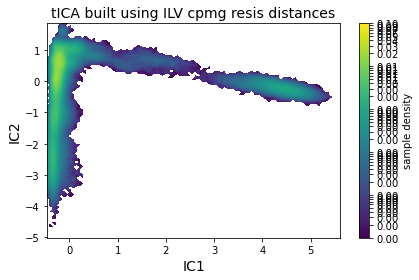

In [4]:
# tica map:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
py.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes, logscale=True)
axes.set_xlabel('IC1', fontsize=14)
axes.set_ylabel('IC2', fontsize=14)
plt.title("tICA built using ILV cpmg resis distances", fontsize=14)
plt.savefig('../figures/c125s_tica_IC1_IC2.png')#, dpi=300)
fig.tight_layout()
plt.show()

#### Each system projected separately

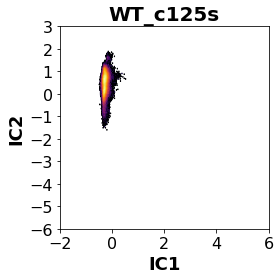

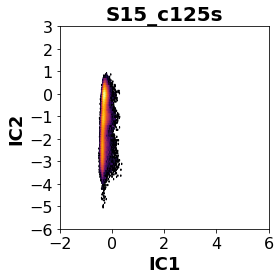

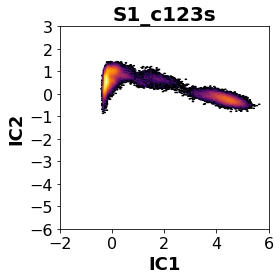

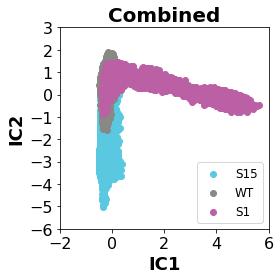

In [5]:
# project each system separately
def generate_tica_plot(IC1_data, IC2_data, title, scatter_point1, scatter_point2):
    plt.figure(figsize=[4,4])
    plt.hexbin(IC1_data, IC2_data, bins='log', cmap='inferno')
    plt.title(title, fontsize=20, weight='bold')
    plt.xlabel("IC1", fontsize=18, weight='bold')
    plt.ylabel("IC2", fontsize=18, weight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(-6,3)
    plt.xlim(-2,6)
    plt.tight_layout()
    plt.savefig(f'../figures/c125s_tica_{title}.png', transparent=True, dpi=300)
    plt.show()
ic1 = tica_concatenated[:, 0:1]
ic2 = tica_concatenated[:, 1:2]
generate_tica_plot(ic1[:250100],         ic2[:250100],        'WT_c125s',  [0,0.85],    [1.2,-1])
generate_tica_plot(ic1[250100:250100*2], ic2[250100:250100*2],'S15_c125s', [0.25,0.85], [2.5,-2])
generate_tica_plot(ic1[250100*2:],       ic2[250100*2:],      'S1_c123s',  [-0.3,0.85], [-1.2,-1])

plt.figure(figsize=[4,4])
plt.scatter(ic1[250100:250100*2],ic2[250100:250100*2],color='#5AC8E0', label='S15')
plt.scatter(ic1[0:250100],       ic2[0:250100],       color='#888985', label='WT')
plt.scatter(ic1[250100*2:],      ic2[250100*2:],      color='#BC60A5', label='S1')
plt.title("Combined", fontsize=20, weight='bold')
plt.xlabel("IC1", fontsize=18, weight='bold')
plt.ylabel("IC2", fontsize=18, weight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-6,3)
plt.xlim(-2,6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f'../figures/c125s_tica_all.png')
plt.show()

### tica: top features

#### Calculate top features

In [6]:
# make atom pairs
IL_WT_S15_resin = '12 14 17 18 19 21 24 25 36 40 53 59 63 66 70 89 94 96 114 118 122 128 129 132'
V_WT_S15_resin  = '91 93'
IL_S1_resin     = '12 14 17 18 19 21 24 25 36 40 53 59 63 66 70 87 92 94 112 116 120 126 127 130'
V_S1_resin      = '89 91'
atom_indices_IL = top_file.topology.select(f'residue {IL_WT_S15_resin} and name CD1')
atom_indices_V = top_file.topology.select(f'residue {V_WT_S15_resin} and name CG1')
atom_indices1 = np.unique(np.concatenate([atom_indices_IL, atom_indices_V])) # put in order
atom_indices = np.unique(atom_indices1)
atom_pairs = list(itertools.combinations(atom_indices, 2))
print(len(atom_pairs))
resi_n_names = []
for i in range(len(atom_indices1)):
    resi_n_names.append(top_file.topology.atom(atom_indices[i]).residue)
print(resi_n_names)
distances_feat = py.coordinates.featurizer(top_file)
distances_feat.add_distances(atom_pairs)
pairs_of_resis = list(distances_feat.describe())

# find top features 
r2 = np.transpose(np.concatenate(distances_data_all, axis = 0))
print('\nTOP FEATURES FOR TICA PLOT (COMBINED WT S1 and S15 SIMULATIONS)')
print("(number of features, values): ", r2.shape)
# for each feature, find its standard deviation
standard_deviations = []
for i in range(len(r2)):
    standard_deviations.append(np.std(r2[i]))
V = tica.eigenvectors
tIC1 = V[:,0]
tIC2 = V[:,1]
tIC3 = V[:,2]
normalized_tIC1 = tIC1 * standard_deviations
normalized_tIC2 = tIC2 * standard_deviations
normalized_tIC3 = tIC3 * standard_deviations
# save normalized tICs:
normalized_tIC_list = [normalized_tIC1,normalized_tIC2, normalized_tIC3]
t=5 # how many features to print out
tICs_list_for_feature_printing = normalized_tIC_list
for c in range(len(tICs_list_for_feature_printing)):
    top_features = np.argsort(-np.abs(tICs_list_for_feature_printing[c]))
    print("\nIC",c+1, top_features[0:t])
    for i in range(t):
        which_pair = top_features[i]
        print(i, list(distances_feat.describe())[which_pair])


325
[LEU12, LEU14, LEU17, LEU18, LEU19, LEU21, ILE24, LEU25, LEU36, LEU40, LEU53, LEU59, LEU63, LEU66, LEU70, ILE89, VAL91, VAL93, LEU94, LEU96, ILE114, LEU118, ILE122, ILE128, ILE129, LEU132]

TOP FEATURES FOR TICA PLOT (COMBINED WT S1 and S15 SIMULATIONS)
(number of features, values):  (325, 750300)

IC 1 [ 56  34  60  38 151]
0 DIST: LEU 17 CD1 258 - LEU 53 CD1 883
1 DIST: LEU 14 CD1 207 - LEU 59 CD1 987
2 DIST: LEU 17 CD1 258 - LEU 70 CD1 1171
3 DIST: LEU 14 CD1 207 - ILE 89 CD1 1494
4 DIST: ILE 24 CD1 384 - ILE 128 CD1 2115

IC 2 [201 137 136 172 198]
0 DIST: LEU 40 CD1 653 - ILE 122 CD1 2023
1 DIST: ILE 24 CD1 384 - LEU 40 CD1 653
2 DIST: ILE 24 CD1 384 - LEU 36 CD1 579
3 DIST: LEU 36 CD1 579 - LEU 40 CD1 653
4 DIST: LEU 40 CD1 653 - LEU 96 CD1 1608

IC 3 [241 171 279 268  56]
0 DIST: LEU 63 CD1 1051 - ILE 114 CD1 1872
1 DIST: LEU 25 CD1 399 - LEU 132 CD1 2174
2 DIST: ILE 89 CD1 1494 - LEU 132 CD1 2174
3 DIST: LEU 70 CD1 1171 - ILE 129 CD1 2134
4 DIST: LEU 17 CD1 258 - LEU 53 CD1

#### Plot top features

34 0.14559054275028277 DIST: LEU 14 CD1 207 - LEU 59 CD1 987
56 0.5598211901969583 DIST: LEU 17 CD1 258 - LEU 53 CD1 883
60 0.14194823744218812 DIST: LEU 17 CD1 258 - LEU 70 CD1 1171


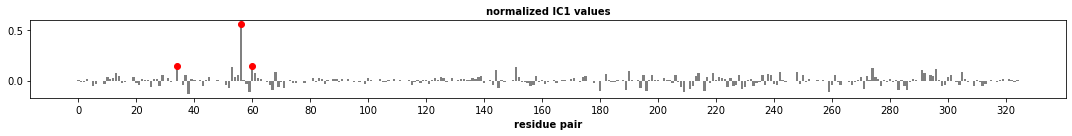

136 -0.315382995910347 DIST: ILE 24 CD1 384 - LEU 36 CD1 579
137 0.37220620520238407 DIST: ILE 24 CD1 384 - LEU 40 CD1 653
201 -0.42183238082353597 DIST: LEU 40 CD1 653 - ILE 122 CD1 2023


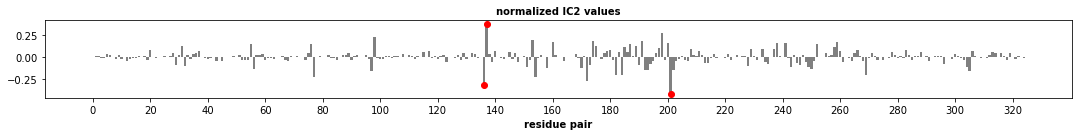

In [7]:
plt.figure(figsize=[15,2])
plt.bar(np.arange(len(normalized_tIC1)), normalized_tIC1, color='gray')
for i in range(len(normalized_tIC1)):
    if np.abs(normalized_tIC1[i]) > 0.14:
       plt.scatter(i,normalized_tIC1[i],color='r') 
       print(i, normalized_tIC1[i], list(distances_feat.describe())[i])
plt.xlabel('residue pair', fontsize=10, weight='bold')
plt.xticks(np.arange(0, len(normalized_tIC1), 20))
plt.title('normalized IC1 values', fontsize=10, weight='bold')
plt.tight_layout()
plt.savefig('../figures/c125s_normalized_IC1_dot_top_values.png')
plt.show()

plt.figure(figsize=[15,2])
plt.bar(np.arange(len(normalized_tIC2)), normalized_tIC2, color='gray')
for i in range(len(normalized_tIC2)):
    if np.abs(normalized_tIC2[i]) > 0.3:
       plt.scatter(i,normalized_tIC2[i],color='r') 
       print(i, normalized_tIC2[i], list(distances_feat.describe())[i])
plt.xlabel('residue pair', fontsize=10, weight='bold')
plt.xticks(np.arange(0, len(normalized_tIC2), 20))
plt.title('normalized IC2 values', fontsize=10, weight='bold')
plt.tight_layout()
plt.savefig('../figures/c125s_normalized_IC2_dot_top_values.png')
plt.show()

## plot distance distributions

### Individual 

In [8]:
r2_wt = np.transpose(np.concatenate(distances_data_wt, axis=0))
r2_s15= np.transpose(np.concatenate(distances_data_s15, axis=0))
r2_s1 = np.transpose(np.concatenate(distances_data_s1,  axis=0))

In [48]:
def plot_dist(n):
    WT_n =  r2_wt[n]
    S15_n= r2_s15[n] 
    S1_n =  r2_s1[n]
    plt.figure(figsize=[6,3])
    angstrom = r'$\bf{\AA}$'
    plt.xlabel(f"{list(distances_feat.describe())[n]}", fontsize=14, weight='bold')
    plt.ylabel('Density',fontsize=14, weight='bold')
    sns.kdeplot(WT_n*10,  c='#888985', label='WT',   linewidth=5)
    sns.kdeplot(S15_n*10, c='#5AC8E0', label='S15',   linewidth=5)
    sns.kdeplot(S1_n*10,  c='#BC60A5', label='S1',   linewidth=5)
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(f'../figures/distance_distribution_WT_S15_S1_c125s_pair_{n}.pdf', transparent=False, dpi=150)
    plt.show()

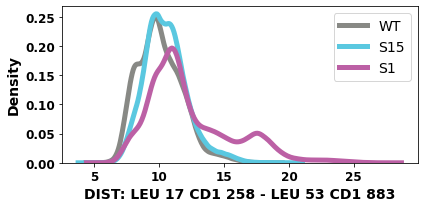

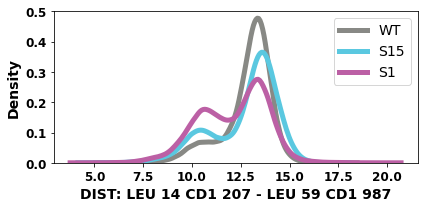

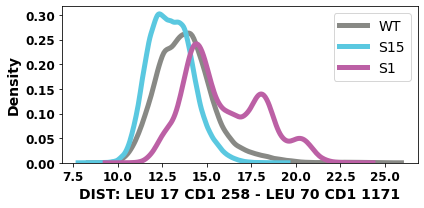

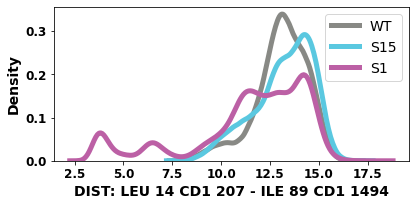

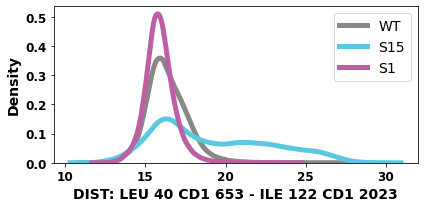

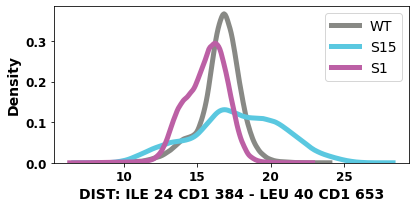

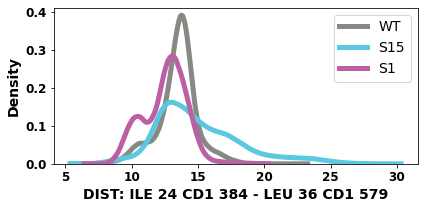

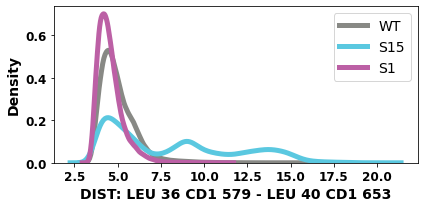

In [52]:
for i in [56, 34, 60, 38, 201, 137, 136, 172]:
    plot_dist(i)

# Include L56A and V84A

# calculation

In [18]:
def mut_tica_projection(mut):
    distances_data_s1_mut = np.load(f'../data/system_seq1_{mut}_distances_cpmg_ILV.npy')
    print(len(distances_data_s1_mut[0][0]))
    distances_tica_output_set2_on_set1 = tica.transform(list(distances_data_s1_mut))
    distances_tica_concatenated_set2_on_set1 = np.concatenate(distances_tica_output_set2_on_set1)
    
    ic1 = tica_concatenated[:, 0:1]
    ic2 = tica_concatenated[:, 1:2]
    ic1_mut = distances_tica_concatenated_set2_on_set1[:, 0:1]
    ic2_mut = distances_tica_concatenated_set2_on_set1[:, 1:2]
    ic1_ic2_mut = np.concatenate((ic1_mut,ic2_mut), axis=1)
    
    ic1_mut_concat = np.concatenate(ic1_mut)
    ic2_mut_concat = np.concatenate(ic2_mut)
    
    return distances_data_s1_mut, ic1_mut_concat, ic2_mut_concat

In [19]:
distances_data_s1_L56A, ic1_L56A, ic2_L56A = mut_tica_projection('c123s_L56A')
distances_data_s1_V84A, ic1_V84A, ic2_V84A = mut_tica_projection('c123s_V84A')
r2_L56A = np.transpose(np.concatenate(distances_data_s1_L56A, axis=0))
r2_V84A = np.transpose(np.concatenate(distances_data_s1_V84A, axis=0))

325
325


In [45]:
def plot_hexbin(n1,n2):
    WT_n1 =  r2_wt[n1]
    S15_n1= r2_s15[n1] 
    S1_n1 =  r2_s1[n1]
    L56A_n1 = r2_L56A[n1]
    V84A_n1 = r2_V84A[n1]
    WT_n2 =  r2_wt[n2]
    S15_n2= r2_s15[n2] 
    S1_n2 =  r2_s1[n2]
    L56A_n2 = r2_L56A[n2]
    V84A_n2 = r2_V84A[n2]

    plt.figure(figsize=[3,3])
    plt.xlim(0,3)
    plt.ylim(0,3)
    plt.title('S15', weight='bold')
    plt.hexbin(S15_n1, S15_n2, bins='log')
    plt.xlabel(f'{list(distances_feat.describe())[n1]}',fontsize=8)
    plt.ylabel(f'{list(distances_feat.describe())[n2]}',fontsize=8)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=[3,3])
    plt.xlim(0,3)
    plt.ylim(0,3)
    plt.title('WT', weight='bold')
    plt.hexbin(WT_n1, WT_n2, bins='log')
    plt.xlabel(f'{list(distances_feat.describe())[n1]}',fontsize=8)
    plt.ylabel(f'{list(distances_feat.describe())[n2]}',fontsize=8)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=[3,3])
    plt.xlim(0,3)
    plt.ylim(0,3)
    plt.title('L56A', weight='bold')
    plt.hexbin(L56A_n1, L56A_n2, bins='log')
    plt.xlabel(f'{list(distances_feat.describe())[n1]}',fontsize=8)
    plt.ylabel(f'{list(distances_feat.describe())[n2]}',fontsize=8)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=[3,3])
    plt.xlim(0,3)
    plt.ylim(0,3)
    plt.title('S1', weight='bold')
    plt.hexbin(S1_n1, S1_n2, bins='log')
    plt.xlabel(f'{list(distances_feat.describe())[n1]}',fontsize=8)
    plt.ylabel(f'{list(distances_feat.describe())[n2]}',fontsize=8)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=[3,3])
    plt.xlim(0,3)
    plt.ylim(0,3)
    plt.title('V84A', weight='bold')
    plt.hexbin(V84A_n1, V84A_n2, bins='log')
    plt.xlabel(f'{list(distances_feat.describe())[n1]}',fontsize=8)
    plt.ylabel(f'{list(distances_feat.describe())[n2]}',fontsize=8)
    plt.tight_layout()
    plt.show()



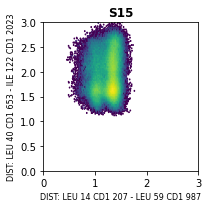

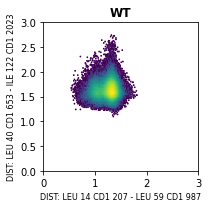

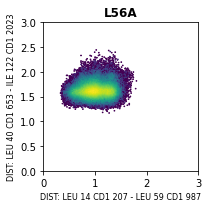

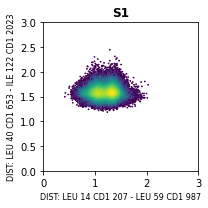

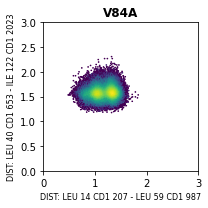

In [46]:
plot_hexbin(34,201)

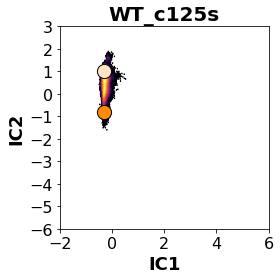

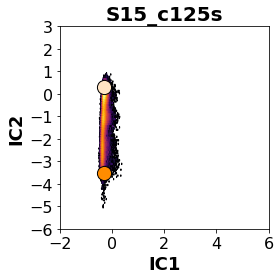

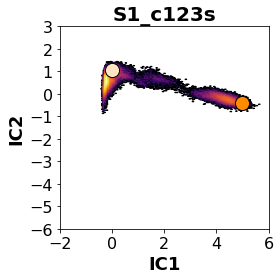

In [44]:
def generate_tica_plot(IC1_data, IC2_data, title, scatter_point1, scatter_point2):
    plt.figure(figsize=[4,4])
    plt.hexbin(IC1_data, IC2_data, bins='log', cmap='inferno')
    plt.scatter(scatter_point1[0], scatter_point1[1], color='bisque', edgecolor='k',s=200)
    plt.scatter(scatter_point2[0], scatter_point2[1], color='darkorange', edgecolor='k', s=200)
    plt.title(title, fontsize=20, weight='bold')
    plt.xlabel("IC1", fontsize=18, weight='bold')
    plt.ylabel("IC2", fontsize=18, weight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(-6,3)
    plt.xlim(-2,6)
    plt.tight_layout()
    plt.savefig(f'../figures/c125s_tica_{title}_labeled.png', transparent=True, dpi=300)
    plt.show()
ic1 = tica_concatenated[:, 0:1]
ic2 = tica_concatenated[:, 1:2]
generate_tica_plot(ic1[:250100],         ic2[:250100],        'WT_c125s',  [-0.30935416, 1], [-0.30865714,-0.8])
generate_tica_plot(ic1[250100:250100*2], ic2[250100:250100*2],'S15_c125s', [-0.30935416, 0.28505135], [-0.30865714,-3.4983206])
generate_tica_plot(ic1[250100*2:],       ic2[250100*2:],      'S1_c123s',  [0.01403588,1.0658622],    [4.9791713, -0.39920655])
#generate_tica_plot(ic1_L56A, ic2_L56A,      'S1_c123s_L56A',  [-0.3,0.85], [-1.2,-1])
#generate_tica_plot(ic1_V84A, ic2_V84A,      'S1_c123s_V84A',  [-0.3,0.85], [-1.2,-1])

In [53]:
def plot_dist_mut(n):
    WT_n = r2_wt[n]
    S15_n= r2_s15[n] 
    S1_n = r2_s1[n]
    L56A_n=r2_L56A[n]
    V84A_n=r2_V84A[n]
    
    plt.figure(figsize=[6,3])
    angstrom = r'$\bf{\AA}$'
    plt.xlabel(f"{list(distances_feat.describe())[n]}", fontsize=10, weight='bold')
    plt.ylabel('Density',fontsize=14, weight='bold')
    sns.kdeplot(WT_n*10,  c='#888985', label='WT',   linewidth=5)
    sns.kdeplot(S15_n*10, c='#5AC8E0', label='S15',   linewidth=5)
    sns.kdeplot(S1_n*10,  c='#BC60A5', label='S1',   linewidth=5)
    sns.kdeplot(L56A_n*10,c='lightgray', label='L56A',   linewidth=5)
    sns.kdeplot(V84A_n*10,c='lightpink', label='V84A',   linewidth=5)
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f'../figures/distance_distribution_WT_S15_S1_mutants_c125s_pair_{n}.pdf', transparent=False, dpi=150)
    plt.show()

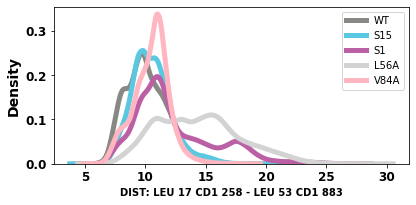

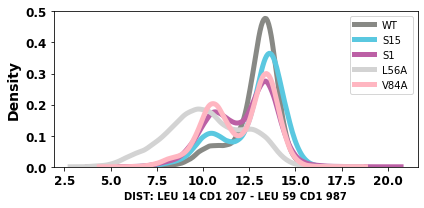

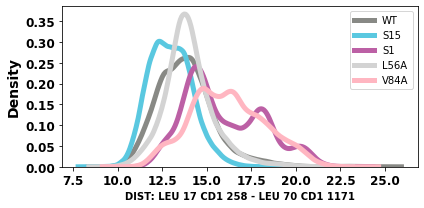

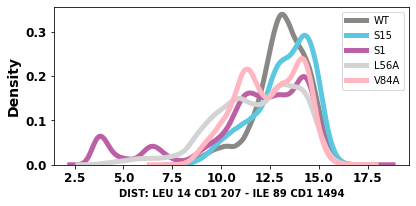

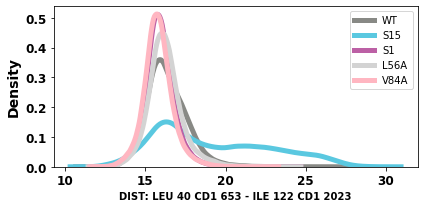

In [51]:
for i in [56, 34, 60, 38, 201]:  
    plot_dist_mut(i)

# Psuedo trajectories

In [91]:
wt_traj_frames = []
s15_traj_frames = []
s1_traj_frames = []
for gen in range(10):
    for kid in range(10):
        for frame in range(2501):
            wt_traj_frames.append( f'wt__gen{gen}_kid{kid}_frame{frame}')
            s15_traj_frames.append(f's15_gen{gen}_kid{kid}_frame{frame}')
            s1_traj_frames.append( f's1__gen{gen}_kid{kid}_frame{frame}')
traj_frames_list = np.concatenate([wt_traj_frames,s15_traj_frames,s1_traj_frames])
print(len(traj_frames_list))

750300


In [201]:
traj_frames_list[700000-10000]

's1__gen7_kid5_frame2225'

In [189]:
n1 = 0.35/5
n2 = 0.1/4.8
print(len(np.arange(0,5,n1)), len(np.arange(-0.5,1,n2)))
print(np.arange(0,5,n1), np.arange(-0.5,1,n2))

72 72
[0.   0.07 0.14 0.21 0.28 0.35 0.42 0.49 0.56 0.63 0.7  0.77 0.84 0.91
 0.98 1.05 1.12 1.19 1.26 1.33 1.4  1.47 1.54 1.61 1.68 1.75 1.82 1.89
 1.96 2.03 2.1  2.17 2.24 2.31 2.38 2.45 2.52 2.59 2.66 2.73 2.8  2.87
 2.94 3.01 3.08 3.15 3.22 3.29 3.36 3.43 3.5  3.57 3.64 3.71 3.78 3.85
 3.92 3.99 4.06 4.13 4.2  4.27 4.34 4.41 4.48 4.55 4.62 4.69 4.76 4.83
 4.9  4.97] [-5.00000000e-01 -4.79166667e-01 -4.58333333e-01 -4.37500000e-01
 -4.16666667e-01 -3.95833333e-01 -3.75000000e-01 -3.54166667e-01
 -3.33333333e-01 -3.12500000e-01 -2.91666667e-01 -2.70833333e-01
 -2.50000000e-01 -2.29166667e-01 -2.08333333e-01 -1.87500000e-01
 -1.66666667e-01 -1.45833333e-01 -1.25000000e-01 -1.04166667e-01
 -8.33333333e-02 -6.25000000e-02 -4.16666667e-02 -2.08333333e-02
 -4.44089210e-16  2.08333333e-02  4.16666667e-02  6.25000000e-02
  8.33333333e-02  1.04166667e-01  1.25000000e-01  1.45833333e-01
  1.66666667e-01  1.87500000e-01  2.08333333e-01  2.29166667e-01
  2.50000000e-01  2.70833333e-01  2.916666

72 72
[0.   0.07 0.14 0.21 0.28 0.35 0.42 0.49 0.56 0.63 0.7  0.77 0.84 0.91
 0.98 1.05 1.12 1.19 1.26 1.33 1.4  1.47 1.54 1.61 1.68 1.75 1.82 1.89
 1.96 2.03 2.1  2.17 2.24 2.31 2.38 2.45 2.52 2.59 2.66 2.73 2.8  2.87
 2.94 3.01 3.08 3.15 3.22 3.29 3.36 3.43 3.5  3.57 3.64 3.71 3.78 3.85
 3.92 3.99 4.06 4.13 4.2  4.27 4.34 4.41 4.48 4.55 4.62 4.69 4.76 4.83
 4.9  4.97] [-5.00000000e-01 -4.79166667e-01 -4.58333333e-01 -4.37500000e-01
 -4.16666667e-01 -3.95833333e-01 -3.75000000e-01 -3.54166667e-01
 -3.33333333e-01 -3.12500000e-01 -2.91666667e-01 -2.70833333e-01
 -2.50000000e-01 -2.29166667e-01 -2.08333333e-01 -1.87500000e-01
 -1.66666667e-01 -1.45833333e-01 -1.25000000e-01 -1.04166667e-01
 -8.33333333e-02 -6.25000000e-02 -4.16666667e-02 -2.08333333e-02
 -4.44089210e-16  2.08333333e-02  4.16666667e-02  6.25000000e-02
  8.33333333e-02  1.04166667e-01  1.25000000e-01  1.45833333e-01
  1.66666667e-01  1.87500000e-01  2.08333333e-01  2.29166667e-01
  2.50000000e-01  2.70833333e-01  2.916666

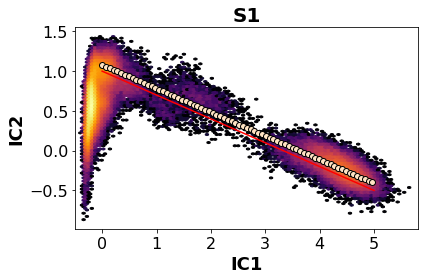

In [190]:
n1 = 0.35/5
n2 = 0.1/4.8
print(len(np.arange(0,5,n1)), len(np.arange(-0.5,1,n2)))
print(np.arange(0,5,n1), np.arange(-0.5,1,n2))

linex = np.arange(0,5,n1)
liney = (np.arange(-0.5,1,n2)+0.1)[::-1]

plt.figure(figsize=[6,4])
plt.hexbin(ic1[250100*2:], ic2[250100*2:], bins='log', cmap='inferno')
plt.title('S1', fontsize=20, weight='bold')
plt.xlabel("IC1", fontsize=18, weight='bold')
plt.ylabel("IC2", fontsize=18, weight='bold')
plt.plot([0,5],[1,-0.5], color='red')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(-6,3)
#plt.xlim(-2,6)
plt.xlim(-0.5,5.8)

for i in range(len(linex)):
    plt.scatter(linex[i],liney[i], color='bisque', edgecolor='k')

plt.tight_layout()
plt.show()


In [191]:
ind_frames = []
ic1_ind_frames = []
ic2_ind_frames = []
for value in range(len(linex)):
    for i in range(len(ic1[250100*2:])):
        if linex[value]-0.02 <= ic1[250100*2:][i] <= linex[value]+0.02 and liney[value]-0.02 <= ic2[250100*2:][i] <= liney[value]+0.02:
            print(i+(250100*2))
            ind_frames.append(i+(250100*2))
            ic1_ind_frames.append(ic1[250100*2:][i])
            ic2_ind_frames.append(ic2[250100*2:][i])
            break
print(len(ic1_ind_frames))
save_gen = []
save_kid = []
save_frame = []
for i in range(len(ind_frames)):
    print(traj_frames_list[ind_frames[i]], ic1_ind_frames[i], ic2_ind_frames[i])
    save_gen.append(traj_frames_list[ind_frames[i]][7])
    save_kid.append(traj_frames_list[ind_frames[i]][12])
    save_frame.append(traj_frames_list[ind_frames[i]][19:])

which_system = 'seq1_c123s'
directory_path = f'/Users/ssolieva/Desktop/bowman_lab/projects/IL2/simulations/IL2_simulations_{which_system}/FAST_RMSD/msm/'
f = open(f"{directory_path}traj_list.txt", "r")
traj_list = f.read().splitlines()
print(f'Here is an example of a line in traj_list.txt: \n {traj_list[0]}')
pdb_path = f'{directory_path}{which_system}-prot-masses.pdb'

for i in range(len(save_frame)):
    pdb_frame = md.load_frame(traj_list[int(save_gen[i])*10+int(save_kid[i])], index=int(save_frame[i]), top=pdb_path)
    pdb_frame.save(f'/Users/ssolieva/Desktop/frames/{i}_S1_gen{save_gen[i]}_kid{save_kid[i]}_frame{save_frame[i]}.pdb')
    

557088
557255
557094
628908
557090
557289
649349
557334
649281
647844
653423
649744
653362
670854
691266
649559
653369
684381
684639
684214
684162
684273
683679
684325
683793
683775
684369
683675
691149
683526
691688
684628
683752
683525
691707
691706
683662
691740
732503
691643
732509
717007
717001
732636
723060
716994
716955
716890
702390
702689
701731
692073
692645
692079
691767
691782
691966
692025
691957
691815
691771
691969
691776
692017
691902
691908
692182
692289
700459
69
s1__gen2_kid2_frame1866 [0.01403588] [1.0658622]
s1__gen2_kid2_frame2033 [0.0757607] [1.0452925]
s1__gen2_kid2_frame1872 [0.1568091] [1.0296015]
s1__gen5_kid1_frame1157 [0.22498073] [1.0180417]
s1__gen2_kid2_frame1868 [0.26379296] [0.9847192]
s1__gen2_kid2_frame2067 [0.33679658] [0.95645934]
s1__gen5_kid9_frame1590 [0.4090663] [0.9394207]
s1__gen2_kid2_frame2112 [0.48070842] [0.9256272]
s1__gen5_kid9_frame1522 [0.5706284] [0.9040952]
s1__gen5_kid9_frame85 [0.63004583] [0.9105827]
s1__gen6_kid1_frame662 [0.692

## Seq15

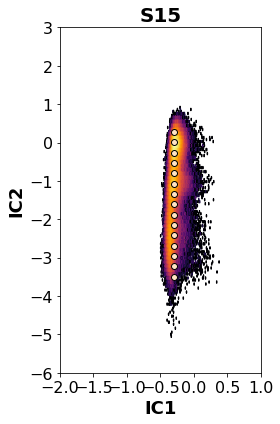

In [175]:
linex = np.array([-0.3]*15) #np.arange(0,5,n1)
liney = np.arange(-3.5,0.5,0.27)[::-1]

plt.figure(figsize=[4,6])
plt.hexbin(ic1[250100:250100*2], ic2[250100:250100*2], bins='log', cmap='inferno')
plt.title('S15', fontsize=20, weight='bold')
plt.xlabel("IC1", fontsize=18, weight='bold')
plt.ylabel("IC2", fontsize=18, weight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-6,3)
#plt.xlim(-2,6)
plt.xlim(-2,1)

for i in range(len(linex)):
    plt.scatter(linex[i],liney[i], color='bisque', edgecolor='k')

plt.tight_layout()
plt.show()

In [180]:
ind_frames = []
ic1_ind_frames = []
ic2_ind_frames = []
for value in range(len(linex)):
    for i in range(len(ic1)):
        if linex[value]-0.01 <= ic1[250100:250100*2][i] <= linex[value]+0.01 and liney[value]-0.01 <= ic2[250100:250100*2][i] <= liney[value]+0.01:
            print(i+250100)
            ind_frames.append(i+250100)
            ic1_ind_frames.append(ic1[250100:250100*2][i])
            ic2_ind_frames.append(ic2[250100:250100*2][i])
            break
            
save_gen = []
save_kid = []
save_frame = []
for i in range(len(ind_frames)):
    print(traj_frames_list[ind_frames[i]], ic1_ind_frames[i], ic2_ind_frames[i])
    save_gen.append(traj_frames_list[ind_frames[i]][7])
    save_kid.append(traj_frames_list[ind_frames[i]][12])
    save_frame.append(traj_frames_list[ind_frames[i]][19:])

which_system = 'seq15_c125s'
directory_path = f'/Users/ssolieva/Desktop/bowman_lab/projects/IL2/simulations/IL2_simulations_{which_system}/FAST_RMSD/msm/'
f = open(f"{directory_path}traj_list.txt", "r")
traj_list = f.read().splitlines()
print(f'Here is an example of a line in traj_list.txt: \n {traj_list[0]}')
pdb_path = f'{directory_path}{which_system}-prot-masses.pdb'

for i in range(len(save_frame)):
    pdb_frame = md.load_frame(traj_list[int(save_gen[i])*10+int(save_kid[i])], index=int(save_frame[i]), top=pdb_path)
    pdb_frame.save(f'/Users/ssolieva/Desktop/frames/{i}_S15_gen{save_gen[i]}_kid{save_kid[i]}_frame{save_frame[i]}.pdb')
    

250955
250179
250875
255576
256909
268695
269337
269794
269725
282811
282845
282747
303107
303909
315350
s15_gen0_kid0_frame855 [-0.30935416] [0.28505135]
s15_gen0_kid0_frame79 [-0.2956689] [0.01080725]
s15_gen0_kid0_frame775 [-0.2923957] [-0.25761604]
s15_gen0_kid2_frame474 [-0.3002709] [-0.53776485]
s15_gen0_kid2_frame1807 [-0.29488394] [-0.7984889]
s15_gen0_kid7_frame1088 [-0.30615905] [-1.0708681]
s15_gen0_kid7_frame1730 [-0.30640063] [-1.3408971]
s15_gen0_kid7_frame2187 [-0.29236782] [-1.6070582]
s15_gen0_kid7_frame2118 [-0.30260158] [-1.8724229]
s15_gen1_kid3_frame198 [-0.30329943] [-2.1499565]
s15_gen1_kid3_frame232 [-0.30295065] [-2.4121358]
s15_gen1_kid3_frame134 [-0.30654725] [-2.6923673]
s15_gen2_kid1_frame486 [-0.30287793] [-2.9604948]
s15_gen2_kid1_frame1288 [-0.3081133] [-3.2384403]
s15_gen2_kid6_frame224 [-0.30865714] [-3.4983206]
Here is an example of a line in traj_list.txt: 
 /Users/ssolieva/Desktop/bowman_lab/projects/IL2/simulations/IL2_simulations_seq15_c125s/FAST_

In [179]:
len(save_frame)

15

In [172]:
len(liney)

15

In [173]:
liney

array([ 0.28,  0.01, -0.26, -0.53, -0.8 , -1.07, -1.34, -1.61, -1.88,
       -2.15, -2.42, -2.69, -2.96, -3.23, -3.5 ])

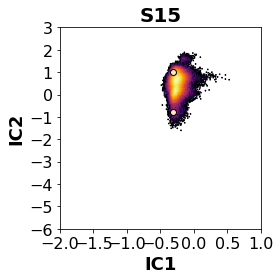

In [89]:


plt.figure(figsize=[4,4])
plt.hexbin(ic1[:250100], ic2[:250100], bins='log', cmap='inferno')
plt.title('S15', fontsize=20, weight='bold')
plt.xlabel("IC1", fontsize=18, weight='bold')
plt.ylabel("IC2", fontsize=18, weight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-6,3)
#plt.xlim(-2,6)
plt.xlim(-2,1)

plt.scatter( -0.30935416, 1, color='bisque', edgecolor='k')
plt.scatter( -0.30865714,-0.8, color='bisque', edgecolor='k')

linex= [-0.30935416,-0.30865714]
liney=[1,-0.8]

plt.tight_layout()
plt.show()

In [93]:
ind_frames = []
ic1_ind_frames = []
ic2_ind_frames = []
for value in range(len(linex)):
    for i in range(len(ic1)):
        if linex[value]-0.01 <= ic1[:250100][i] <= linex[value]+0.01 and liney[value]-0.01 <= ic2[:250100][i] <= liney[value]+0.01:
            print(i)
            ind_frames.append(i)
            ic1_ind_frames.append(ic1[:250100][i])
            ic2_ind_frames.append(ic2[:250100][i])
            break
            
save_gen = []
save_kid = []
save_frame = []
for i in range(len(ind_frames)):
    print(traj_frames_list[ind_frames[i]], ic1_ind_frames[i], ic2_ind_frames[i])
    save_gen.append(traj_frames_list[ind_frames[i]][7])
    save_kid.append(traj_frames_list[ind_frames[i]][12])
    save_frame.append(traj_frames_list[ind_frames[i]][19:])

which_system = '1m47_c125s'
directory_path = f'/Users/ssolieva/Desktop/bowman_lab/projects/IL2/simulations/IL2_simulations_{which_system}/FAST_RMSD/msm/'
f = open(f"{directory_path}traj_list.txt", "r")
traj_list = f.read().splitlines()
print(f'Here is an example of a line in traj_list.txt: \n {traj_list[0]}')
pdb_path = f'{directory_path}{which_system}-prot-masses.pdb'

for i in range(len(save_frame)):
    pdb_frame = md.load_frame(traj_list[int(save_gen[i])*10+int(save_kid[i])], index=int(save_frame[i]), top=pdb_path)
    pdb_frame.save(f'/Users/ssolieva/Desktop/frames/{i}_WT_gen{save_gen[i]}_kid{save_kid[i]}_frame{save_frame[i]}.pdb')
    

29942
14717
wt__gen1_kid1_frame2431 [-0.30687997] [0.9924121]
wt__gen0_kid5_frame2212 [-0.3051892] [-0.8099391]
Here is an example of a line in traj_list.txt: 
 /Users/ssolieva/Desktop/bowman_lab/projects/IL2/simulations/IL2_simulations_1m47_c125s/FAST_RMSD/msm/trajectories/trj_gen000_kid000.xtc
